<a href="https://colab.research.google.com/github/dekings44/students_companion_bot/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This is the codebase of my masters degree project.**

**Project Title:** *How Effective is AI in Delivering Personalized Learning Paths for Students? A Hands-on Approach with Generative AI.*

**The Problem I am trying to solve:** *This project aims to explore the effectiveness of AI in creating personalized learning paths that caters to individual students’ needs, enhancing learning experience and outcomes.*

**Expected End Product**



> A comprehensive report detailing the AI tutor's effectiveness, measured through metrics like student engagement, understanding, performance, and feedback


> AI Bot Web Embedded Application working prototype capable of delivering personalized learning paths for students based on their individual learning styles, paces, and preferences.


> Working code of the AI Bot


**Name of the AI bot**: **Manda**, *the student companion*


Installation of all the libraries, models and modules that will be needed for this project.

In [ ]:
!pip install -U transformers --quiet
!pip install -U accelerate --quiet
!pip install -U bertviz --quiet
!pip install -U umap-learn --quiet
!pip install torch torchvision torchaudio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 103.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.2 MB/s eta 0:00:00


In [ ]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


import torch
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import AutoTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Masters Project/dataset.csv')

In [ ]:
data.head()

,Sentence,Type
0,"Ali, who was two at the time, loved the story ...",Auditory
1,"Look at my dad, spiffed up in jodhpurs, ready ...",Auditory
2,Believe me it's far more difficult to know wha...,Auditory
3,"The Surrealists loved bad movies, seeing them ...",Auditory
4,"He idolised prize-fighters, regarded racketeer...",Auditory


In [ ]:
data['Type'].value_counts()

Visual         5827
Kinesthetic    4819
Auditory       4804
Name: Type, dtype: int64

In [ ]:
num_rows, num_columns = data.shape
f'This dataset has {num_rows} rows and {num_columns} columns'

'This dataset has 15450 rows and 2 columns'

In [ ]:
classes = data['Type'].unique()
classes

array(['Auditory', 'Visual', 'Kinesthetic'], dtype=object)

Reshuffle the DataFrame with the same rows as the original DataFrame, but in a random order. The random_state parameter is used to ensure that the same random sequence is generated each time the code is run.

In [ ]:
# Shuffle the DataFrame
data = data.sample(frac=1, random_state=42)

# Print the shuffled DataFrame
data.head()

,Sentence,Type
150,The little boy put ooo at the end of his lette...,Auditory
3465,"He looks livid, however, and I'm dreading the ...",Visual
14109,A blond girl giggled softly as a boy whispered...,Kinesthetic
1547,The more recent focus of gender research based...,Visual
903,We had plenty of time to admire the water clar...,Visual


In [ ]:
# This Function is to clean the dataset and remove the noise
def cleanData(data):
  data = re.sub(r'@[A-Za-z0-9_]+', '', data) # this will remove the @ mentions
  data = re.sub(r'#', '', data) # this will remove the # symbols
  data = re.sub(r'https?:\/\/\s+', '', data) # This will remove the hyperlink
  data = re.sub(r'\n+', '', data) # This will removes all mention of \n
  data = re.sub(r'_', '', data) # This will remove _
  data = re.sub(r'[0-9]', '', data) # This will remove numbers
  return data

In [ ]:
data['cleaned_conversation'] = data['Sentence'].apply(cleanData)

**Exploratory Data Analysis**

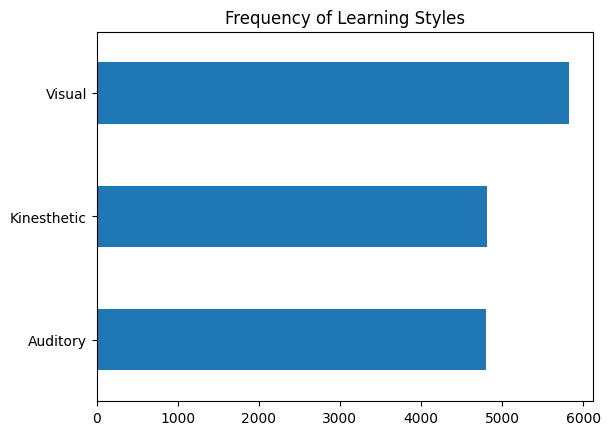

In [ ]:
learning_styles = data['Type'].value_counts(ascending=True)
learning_styles.plot.barh()
plt.title('Frequency of Learning Styles')
plt.show()

<Axes: title={'center': 'Words Per Conversation'}, xlabel='Type'>

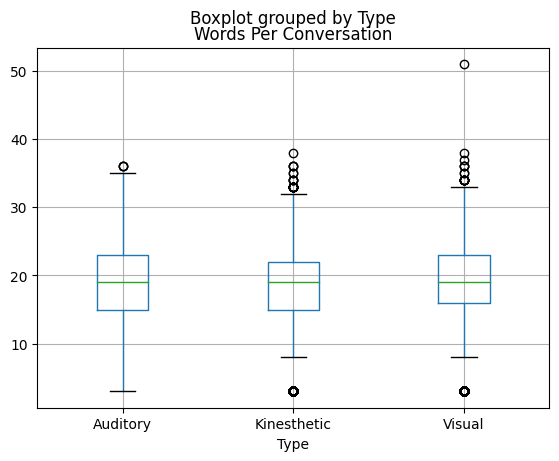

In [ ]:
data['Words Per Conversation'] = data['cleaned_conversation'].str.split().apply(len)
data.boxplot("Words Per Conversation", by='Type')

In [ ]:
# Assuming df is your DataFrame and 'Type' is the column with labels
labels = data['Type']

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
numerical_labels = label_encoder.fit_transform(labels)

# Add the numerical labels to the DataFrame as a new column, let's call it 'Label'
data['Label'] = numerical_labels

In [ ]:
classes = data['Label'].unique()
classes

array([0, 2, 1])

In [ ]:
data.head()

,Sentence,Type,cleaned_conversation,Words Per Conversation,Label
150,The little boy put ooo at the end of his lette...,Auditory,The little boy put ooo at the end of his lette...,20,0
3465,"He looks livid, however, and I'm dreading the ...",Visual,"He looks livid, however, and I'm dreading the ...",20,2
14109,A blond girl giggled softly as a boy whispered...,Kinesthetic,A blond girl giggled softly as a boy whispered...,17,1
1547,The more recent focus of gender research based...,Visual,The more recent focus of gender research based...,21,2
903,We had plenty of time to admire the water clar...,Visual,We had plenty of time to admire the water clar...,23,2


In [ ]:
data.shape

(15450, 5)

In [ ]:
data.tail()

,Sentence,Type,cleaned_conversation,Words Per Conversation,Label
5191,"The genesis, the objective aim, object and com...",Visual,"The genesis, the objective aim, object and com...",22,2
13418,When she blushed it gradually became more indi...,Kinesthetic,When she blushed it gradually became more indi...,26,1
5390,"Wondrous as that icy, frozen scenary might hav...",Visual,"Wondrous as that icy, frozen scenary might hav...",34,2
860,It will give some clarity to one's understandi...,Visual,It will give some clarity to one's understandi...,14,2
7270,The only advice to those players is that they ...,Auditory,The only advice to those players is that they ...,21,0


In [ ]:
sentences = data['cleaned_conversation'].tolist()
learn_style = data['Label'].tolist()

In [ ]:
len(sentences)

15450

In [ ]:
type(sentences)

list

In [ ]:
len(learn_style)

15450

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenized_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

#tokenized_inputs_array =  np.array(tokenized_inputs) #tokenized_inputs.numpy()

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(len(tokenized_inputs), len(learn_style))

3 15450


In [ ]:
tokenized_inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
tokenized_inputs['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [ ]:
print(len(tokenized_inputs['token_type_ids']), len(learn_style))

15450 15450


In [ ]:
tokenized_sentences = tokenized_inputs['input_ids']

In [ ]:
print(len(tokenized_inputs['input_ids']), len(learn_style))

15450 15450


In [ ]:
tokens_first_row = tokenized_inputs['input_ids'][0]

In [ ]:
tokens_first_row

tensor([  101,  1996,  2210,  2879,  2404,  1051,  9541,  2012,  1996,  2203,
         1997,  2010,  3661,  2000, 13055,  1010,  2000,  2292,  2014,  2113,
         2002,  3866,  2014,  1012,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
first_row_from_tokens = tokenizer.convert_ids_to_tokens(tokens_first_row)

In [ ]:
first_row_from_tokens

['[CLS]',
 'the',
 'little',
 'boy',
 'put',
 'o',
 '##oo',
 'at',
 'the',
 'end',
 'of',
 'his',
 'letter',
 'to',
 'grandma',
 ',',
 'to',
 'let',
 'her',
 'know',
 'he',
 'loved',
 'her',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
print(tokenized_inputs['token_type_ids'])

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [ ]:
input_ids = tokenized_inputs['input_ids']
token_type_ids = tokenized_inputs['token_type_ids']
attention_mask = tokenized_inputs['attention_mask']

**Split Data into Train Validate and Test**

In [ ]:
# Splitting the dataset
train_input_ids, test_input_ids, train_token_type_ids, test_token_type_ids, train_attention_mask, test_attention_mask, train_labels, test_labels = train_test_split(
    input_ids, token_type_ids, attention_mask, learn_style, test_size=0.2, random_state=42
)

train_input_ids, val_input_ids, train_token_type_ids, val_token_type_ids, train_attention_mask, val_attention_mask, train_labels, val_labels = train_test_split(
    train_input_ids, train_token_type_ids, train_attention_mask, train_labels, test_size=0.1, random_state=42
)

In [ ]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    tokenized_sentences, learn_style, test_size=0.2, random_state=42
)

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    train_inputs, train_labels, test_size=0.1, random_state=42
)


In [ ]:
train_inputs

tensor([[  101,  4463,  2356,  ...,     0,     0,     0],
        [  101,  1996,  7577,  ...,     0,     0,     0],
        [  101,  2010,  2376,  ...,     0,     0,     0],
        ...,
        [  101, 15547,  5162,  ...,     0,     0,     0],
        [  101,  2002,  2056,  ...,     0,     0,     0],
        [  101, 10616,  1996,  ...,     0,     0,     0]])

We convert the input data into PyTorch datasets (TensorDataset) and create data loaders to iterate over batches during training, validation, and testing.

In [ ]:
train_dataset = torch.utils.data.TensorDataset(train_input_ids, train_attention_mask, torch.tensor(train_labels))
val_dataset = torch.utils.data.TensorDataset(val_input_ids, val_attention_mask, torch.tensor(val_labels))
test_dataset = torch.utils.data.TensorDataset(test_input_ids, test_attention_mask, torch.tensor(test_labels))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)


In [ ]:
print(type(train_dataset))

<class 'torch.utils.data.dataset.TensorDataset'>


I initialize the BERT model (BertForSequenceClassification) for sequence classification with three labels ('Auditory', 'Visual', 'Kinesthetic'). I also set up an AdamW optimizer with a learning rate of 2e-5. The model is then trained for a specified number of epochs. During each epoch, the training data is iterated over in batches, and the model is updated using backpropagation. After each epoch, the model is evaluated on the validation set, and the validation accuracy is printed.

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
optimizer = AdamW(model.parameters(), lr=2e-5)

for epoch in range(2):  # Adjust the number of epochs as needed
    model.train()
    for batch in train_loader:
        inputs, attention_mask, labels = batch
        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation
    model.eval()
    val_predictions = []
    for batch in val_loader:
        inputs, attention_mask, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=attention_mask)
            logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).tolist()
        val_predictions.extend(predictions)

    val_accuracy = accuracy_score(val_labels, val_predictions)
    print(f'Epoch {epoch + 1} - Validation Accuracy: {val_accuracy}')



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 - Validation Accuracy: 0.9506472491909385
Epoch 2 - Validation Accuracy: 0.9555016181229773


In [ ]:
model.save_pretrained("/content/drive/MyDrive/Masters Project/")
model.eval()
test_predictions = []
for batch in test_loader:
    inputs, attention_mask, labels = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=attention_mask)
        logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).tolist()
    test_predictions.extend(predictions)

test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy}')


Test Accuracy: 0.9533980582524272


In [2]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the trained model
model_path = "/content/drive/MyDrive/Masters Project/"  # Path to your saved model
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Input text to test
input_text = "the cost of gaining formal education is unappologetically expensive, I truly feel for the low income earners the society"

# Tokenize the input text
inputs = tokenizer(input_text, return_tensors="pt")

# Ensure correct input formatting
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Feed the input to the model for prediction
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits

# Get the predicted label
predicted_label = torch.argmax(logits, dim=1).item()
print(f"Predicted Label Index: {predicted_label}")


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Predicted Label Index: 1


In [7]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the trained model
model_path = "/content/drive/MyDrive/Masters Project/"  # Path to your saved model
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Input text to test
input_text = [ "the cost of gaining formal education is unappologetically expensive, I truly feel for the low income earners the society"]
# input_text1 = ["I understand the material best when I listen to the teacher explain it rather than reading it myself"]

# Tokenize the input text
inputs = tokenizer(input_text, padding=True, truncation=True,  return_tensors="pt")

# Ensure correct input formatting
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Feed the input to the model for prediction
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits

# Get the predicted label
predicted_label = torch.argmax(logits, dim=1).item()
print(f"Predicted Label Index: {predicted_label}")


Predicted Label Index: 1


In [8]:
# Load the trained model
model_path = "/content/drive/MyDrive/Masters Project/"  # Path to your saved model
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Input text to test
input_text = ["my name is Salome, I am business analyst and I am so passionate about my skills, my life and family also like relaxing on my free time, currently I will working as a clinical support worker. Hopefully I will return as a Business analyst"]

# Tokenize the input text
inputs = tokenizer(input_text, return_tensors="pt")

# Ensure correct input formatting
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Feed the input to the model for prediction
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits

# Get the predicted label
predicted_label = torch.argmax(logits, dim=1).item()
if predicted_label == 0:
   print("You are an Autitory learner")
elif predicted_label == 1:
  print("Your are a Kinesthetic learner")
else:
  print("You are a Visual learner")
print(f"Predicted Label Index: {predicted_label}")

You are an Autitory learner
Predicted Label Index: 0


In [4]:
# Load the trained model
model_path = "/content/drive/MyDrive/Masters Project/"  # Path to your saved model
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Input text to test
input_text = [""]

# Tokenize the input text
inputs = tokenizer(input_text, return_tensors="pt")

# Ensure correct input formatting
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Feed the input to the model for prediction
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits

# Get the predicted label
predicted_label = torch.argmax(logits, dim=1).item()
if predicted_label == 0:
   print("You are an Autitory learner")
elif predicted_label == 1:
  print("Your are a Kinesthetic learner")
else:
  print("You are a Visual learner")
print(f"Predicted Label Index: {predicted_label}")

You are an Autitory learner
Predicted Label Index: 0
